<img src="https://www.bestdesigns.co/uploads/inspiration_images/4350/990__1511457498_404_walmart.png" alt="WALMART LOGO" />

# Walmart project presentation (predict weekly sales)

## Introduction

### Company's Description 📇

Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores from the United States, headquartered in Bentonville, Arkansas. The company was founded by Sam Walton in 1962.

### Project 🚧

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

### Goals 🎯

The project can be divided into three steps:

- Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning
- Part 2 : train a **linear regression model** (baseline)
- Part 3 : avoid overfitting by training a **regularized regression model**

### Scope of this project 🖼️

For this project, you'll work with a dataset that contains information about weekly sales achieved by different Walmart stores, and other variables such as the unemployment rate or the fuel price, that might be useful for predicting the amount of sales. The dataset has been taken from a Kaggle competition, but we made some changes compared to the original data. Please make sure that you're using **our** custom dataset (available on JULIE). 🤓

## Deliverable

To complete this project, your team should:

- Create some visualizations
- Train at least one **linear regression model** on the dataset, that predicts the amount of weekly sales as a function of the other variables
- Assess the performances of the model by using a metric that is relevant for regression problems
- Interpret the coefficients of the model to identify what features are important for the prediction
- Train at least one model with **regularization (Lasso or Ridge)** to reduce overfitting


# Importing stuff

In [172]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [173]:
dataset = pd.read_csv('Walmart_Store_sales.csv')

# Checking the dataset

## Null values

In [174]:
print(dataset.shape)
dataset.isnull().sum()

(150, 8)


Store            0
Date            18
Weekly_Sales    14
Holiday_Flag    12
Temperature     18
Fuel_Price      14
CPI             12
Unemployment    15
dtype: int64

## Cleaning Weekly_Sales

The goal of the project is to predict the `Weekly_Sales`.  
The `Weekly_Sales` column is missing 14 values. We'll start by removing these 14 rows.

In [175]:
dataset = dataset.loc[dataset['Weekly_Sales'].notnull(),:]

## Reviewing the dataset.

In [176]:
print(dataset.shape)
display(dataset.head())
display(dataset.describe())
dataset.isnull().sum()

(136, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,136.000000,1.360000e+02,125.000000,121.000000,124.000000,125.000000,122.000000
mean,10.014706,1.249536e+06,0.072000,60.853967,3.316992,178.091144,7.665582
std,6.124614,6.474630e+05,0.259528,18.514432,0.479540,40.243105,1.619428
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,6.050757e+05,0.000000,45.220000,2.838500,131.637000,6.690000
50%,10.000000,1.261424e+06,0.000000,62.250000,3.451000,196.919506,7.477000
75%,15.250000,1.806386e+06,0.000000,75.950000,3.724000,214.878556,8.150000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000


Store            0
Date            18
Weekly_Sales     0
Holiday_Flag    11
Temperature     15
Fuel_Price      12
CPI             11
Unemployment    14
dtype: int64

## Missing values ?

In [177]:
#!pip install missingno

<Axes: >

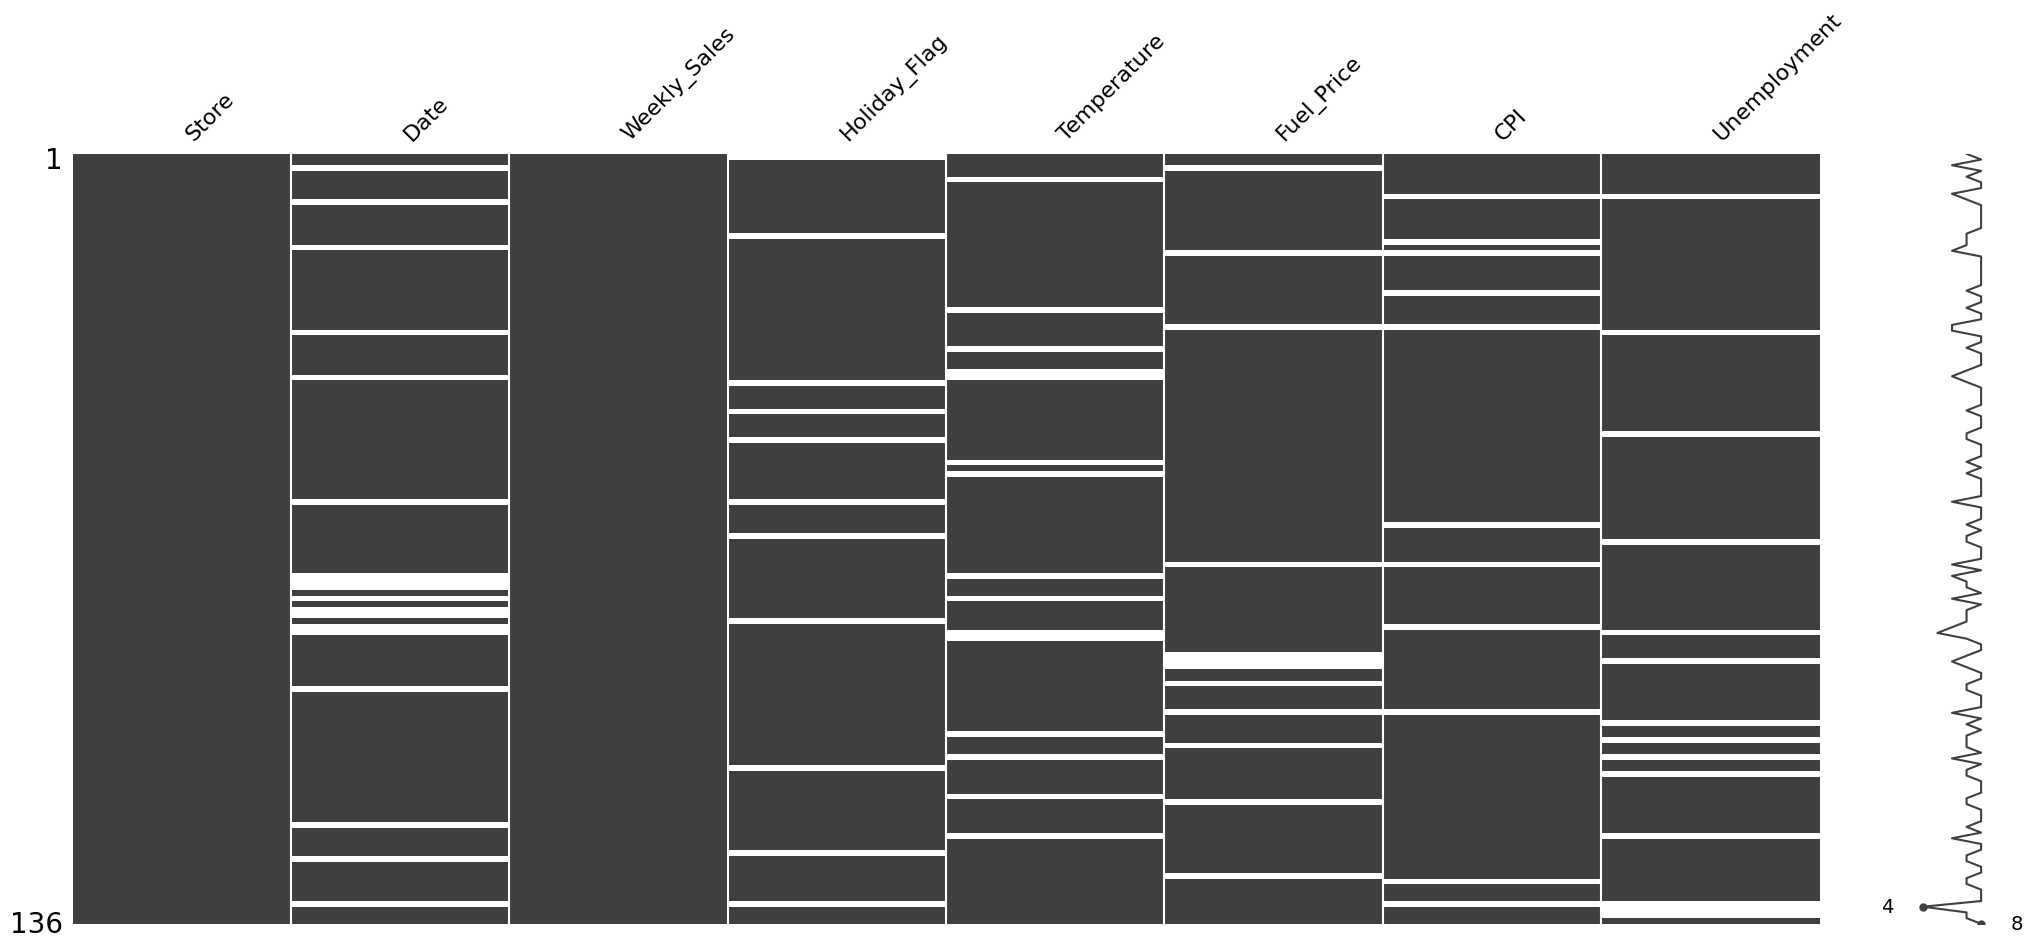

In [178]:
import missingno as msno
msno.matrix(dataset)

## Cleaning Dates

I'll start by removing rows with missing dates to quickstart the project without spending time digging into none straightforward imputing solutions.  
It's 13% of the small 136 rows dataset.

In [179]:
dataset = dataset.loc[dataset['Date'].notnull(),:]

In [180]:
dataset['Date'] = pd.to_datetime(dataset['Date'],dayfirst=True)

In [181]:
dataset.sort_values(by=['Date'], inplace=True)

I want to check weekly sales per store. Even if it's not straight line, we can see clear average performance is very different between stores.

In [182]:
fig0 = px.line(dataset, x='Date', y="Weekly_Sales", color="Store", height=1000, )
fig0.show()
fig0.write_image("graphics/Weekly_sales_per_store.png")

In [183]:
print(dataset.shape)
display(dataset.head())
display(dataset.describe(include='all'))
dataset.isnull().sum()

(118, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
67,3.0,2010-02-05,461622.22,0.0,45.71,2.572,214.424881,7.368
44,1.0,2010-02-12,1641957.44,1.0,38.51,2.548,211.242170,8.106
107,8.0,2010-02-12,994801.40,1.0,33.34,2.548,214.621419,6.299
115,15.0,2010-02-19,660838.75,0.0,NaN,2.909,131.637000,NaN
112,2.0,2010-02-19,2124451.54,0.0,39.69,2.514,210.945160,NaN


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,118.000000,118,1.180000e+02,109.000000,107.000000,107.000000,109.000000,107.000000
mean,9.949153,2011-04-23 04:28:28.474576384,1.257271e+06,0.073394,60.711589,3.291542,177.718009,7.681299
min,1.000000,2010-02-05 00:00:00,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.250000,2010-07-30 00:00:00,5.774276e+05,0.000000,45.465000,2.824000,131.637000,6.664000
50%,9.000000,2011-04-29 00:00:00,1.331001e+06,0.000000,61.790000,3.308000,194.379637,7.484000
75%,15.000000,2011-12-31 18:00:00,1.810591e+06,0.000000,75.430000,3.691500,214.777523,8.150000
max,20.000000,2012-10-19 00:00:00,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000
std,6.066367,NaN,6.625056e+05,0.261987,17.961676,0.486784,39.816657,1.678155


Store            0
Date             0
Weekly_Sales     0
Holiday_Flag     9
Temperature     11
Fuel_Price      11
CPI              9
Unemployment    11
dtype: int64

## Checking all other columns

### `Store` columns

`Store` has 20 distinct values for 118 rows and no missing values. Let's keep the column as is.

In [184]:
display(dataset['Store'].astype('string').describe(include='all'))

count     118
unique     20
top       3.0
freq       10
Name: Store, dtype: object

### `Holiday_Flag` column



`Holiday_Flag` is a Boolean.  
As there are less Holiday weeks in a year than not, I expected less positive `Holiday_Flag`which is the case.
  
  The way `Holiday_Flag` is build is not obvious.  
  It makes smart imputation from external data complex.
    
    I'll go for a dumb strategy replacing missing values with `False`

In [185]:
dataset['Holiday_Flag'].value_counts()

Holiday_Flag
0.0    101
1.0      8
Name: count, dtype: int64

In [186]:
dataset.loc[dataset['Holiday_Flag'].isnull(),'Holiday_Flag'] = 0.0

### `Temperature` column

`Temperature` values are all within 3 std from the mean.  
11 Values are missing.
I'll go for a SimpleImputer with default mean strategy for now.  
KNN could be better as we know average Temperatures are correlated to the period of the year and the geoloc.  
I could not rebuild the column from external data as Temperature is geoloc based and we don't have this information.

### `Fuel_Price` column

`Fuel_Price` values are all within 3 std from the mean.  
11 Values are missing.  
I'll go for a SimpleImputer with default mean strategy for now.  
I could rebuild the column from external data as Fuel_Price is Public data

### `CPI` column

`CPI` values are all within 3 std from the mean.   
9 Values are missing.  
I'll go for a SimpleImputer with default mean strategy for now.   
I could rebuild the column from external data as CPI is Public data

### `Unemployment` column

5 `Unemployment` values are above 3 std from the mean.  
Unemployment do not suffer important daily variations and these values are not even grouped on a period of time.

I'll delete these values but not the rows.

11 Values are missing + 5 deleted atypical values.  
I'll go for a SimpleImputer with default mean strategy for now.

In [187]:
fig1 = px.scatter(dataset, x='Date', y="Unemployment")
fig1.show()
fig1.write_image("graphics/Unemployement.png")

In [188]:
dataset.loc[dataset["Unemployment"] > 12.5,"Unemployment"] = np.NaN

# Preparing our training dataset

## Feature engineering

Let's create features from `Date`
- `Year`
- `Month`
- `Quarter`
- ...  
I'd like to get the `Week_of_Year` data too but it doesn't seem to be native from the `date`methods so I'll skip for now

In [189]:
dataset['Year']= dataset['Date'].dt.year
dataset['Month']= dataset['Date'].dt.month
dataset['Day_of_Week']= dataset['Date'].dt.day_of_week
dataset['Month_start']= dataset['Date'].dt.is_month_start
dataset['Month_end']= dataset['Date'].dt.is_month_end
dataset['Year_end']= dataset['Date'].dt.is_year_end
dataset['Quarter']= dataset['Date'].dt.quarter


In [190]:
dataset = dataset.drop('Date',axis=1)

In [191]:
dataset.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day_of_Week,Month_start,Month_end,Year_end,Quarter
67,3.0,461622.22,0.0,45.71,2.572,214.424881,7.368,2010,2,4,False,False,False,1
44,1.0,1641957.44,1.0,38.51,2.548,211.242170,8.106,2010,2,4,False,False,False,1
107,8.0,994801.40,1.0,33.34,2.548,214.621419,6.299,2010,2,4,False,False,False,1
115,15.0,660838.75,0.0,NaN,2.909,131.637000,NaN,2010,2,4,False,False,False,1
112,2.0,2124451.54,0.0,39.69,2.514,210.945160,NaN,2010,2,4,False,False,False,1


### Checking `Day_of_Week`


All rows are from the same Day_of_Week.
Let's delete the column

In [192]:
dataset['Day_of_Week'].value_counts()

Day_of_Week
4    118
Name: count, dtype: int64

In [193]:
dataset = dataset.drop('Day_of_Week',axis=1)

### Checking `Year`

In [194]:
dataset['Year'].value_counts()

Year
2010    51
2011    37
2012    30
Name: count, dtype: int64

### Checking `Month`

In [195]:
dataset['Month'].value_counts()

Month
5     14
6     14
2     12
7     12
8     11
3     10
4      9
10     8
11     8
12     8
9      7
1      5
Name: count, dtype: int64

### Checking `Quarter`

In [196]:
dataset['Quarter'].value_counts()

Quarter
2    37
3    30
1    27
4    24
Name: count, dtype: int64

### Checking `Month_start`, `Month_end`, `Year_end`


I tought it would be 'among the first days of the month' but it seems it's exactly the first/last day of the Month/Year which make it less interesting given the dataset.  
I'll delete these columns

In [197]:
dataset['Month_start'].value_counts()

Month_start
False    116
True       2
Name: count, dtype: int64

In [198]:
dataset['Month_end'].value_counts()

Month_end
False    115
True       3
Name: count, dtype: int64

In [199]:
dataset['Year_end'].value_counts()

Year_end
False    117
True       1
Name: count, dtype: int64

In [200]:
dataset = dataset.drop(['Month_start','Month_end','Year_end'], axis=1)

## Checking our dataset before first training

In [201]:
# Visualize pairwise dependencies
fig2 = px.scatter_matrix(dataset)
fig2.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False,
            autosize=False, height=2000, width = 2000)
fig2.show()
fig2.write_image("graphics/Bivariate_analysis.png")

In [202]:
# Correlation matrix
corr_matrix = dataset.corr(numeric_only=True).round(2)

import plotly.figure_factory as ff

fig3 = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig3.show()
fig3.write_image("graphics/Feature_correlations.png")

# Training with Linear regression

In [203]:
Y=dataset[["Weekly_Sales"]]
X=dataset.drop('Weekly_Sales', axis=1)

In [204]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [205]:
X_train.columns

Index(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'Year', 'Month', 'Quarter'],
      dtype='object')

In [206]:
num_features = ['Temperature','Fuel_Price','CPI','Unemployment','Year','Month','Quarter']
num_transformer = Pipeline ( steps = [
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

In [207]:
cat_features = ['Store','Holiday_Flag']
cat_transformer = Pipeline ( steps = [
    ('cat_imputer',SimpleImputer(strategy='most_frequent')), # Column are already full
    ('encoder', OneHotEncoder(drop='first'))
])

In [208]:
preprocessor = ColumnTransformer( transformers=[
    ('num', num_transformer, num_features ),
    ('cat', cat_transformer, cat_features ),
])

In [209]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [210]:
# Train model
model = LinearRegression()

model.fit(X_train, Y_train) # Training is always done on train set !!
print("Training completed")

Training completed


In [211]:
print(model.score(X_train,Y_train))
print(model.score(X_test,Y_test))

0.971556708049888
0.9544671703011798


# Analysing coef

In [212]:
coefs = pd.DataFrame(index = preprocessor.get_feature_names_out(), data = model.coef_.transpose(), columns=["coefficients"])
coefs

,coefficients
num__Temperature,-3.373897e+04
num__Fuel_Price,-5.220394e+04
num__CPI,3.599209e+04
num__Unemployment,-3.856546e+04
num__Year,1.335024e+04
num__Month,1.907799e+05
num__Quarter,-1.276880e+05
cat__Store_2.0,3.499435e+05
cat__Store_3.0,-1.262019e+06
cat__Store_4.0,4.347141e+05


In [213]:
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients')
# Plot coefficients
fig4 = px.bar(feature_importance, orientation = 'h')
fig4.update_layout(showlegend = False,
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig4.show()
fig4.write_image("graphics/LinReg_feature_weight.png")

# Fight overfitting

## Let's check if Lasso can help us remove features. Probablility is low.
conclusion is : no features to remove to reduce overfitting

In [214]:
# Perform grid search
print("Grid search...")
regressor = Lasso()
# Grid of values to be tested
params = {
    'alpha': [x*0.1 for x in range(0, 10)] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.0}
Best R2 score :  0.9250690262001419


/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1474: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 341196065858.5768, tolerance: 2677461549.4946294

/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1474: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 341469137258.5656, tolerance: 2723904417.880888

/Users/arthurblanchon

In [215]:
lasso = Lasso(alpha=1)
lasso.fit(X_train, Y_train)
print(lasso.score(X_train, Y_train))
print(lasso.score(X_test, Y_test))

0.9715567042574583
0.954479370640792


In [216]:
lasso = Lasso(alpha=0)
lasso.fit(X_train, Y_train)
print(lasso.score(X_train, Y_train))
print(lasso.score(X_test, Y_test))

0.9715567080517903
0.9544669576694919


/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1474: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 568255405239.8909, tolerance: 3995707713.963554



In [217]:
# Print R^2 scores from simple Linear Regression
print("R2 score on training set : ", model.score(X_train, Y_train))
print("R2 score on test set : ", model.score(X_test, Y_test))

R2 score on training set :  0.971556708049888
R2 score on test set :  0.9544671703011798


In [218]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with a Ridge model
print("3-fold cross-validation...")
scores = cross_val_score(model, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

3-fold cross-validation...
The cross-validated R2-score is :  0.9250691020811076
The standard deviation is :  0.015144435369032665


In [219]:
coefs = pd.DataFrame(index = preprocessor.get_feature_names_out(), \
                     data = gridsearch.best_estimator_.coef_, \
                     columns=["values"]).reset_index(names=['Features'] \
                    )
coefs['values']=abs(coefs['values'])
coefs.sort_values('values', ascending=False)

,Features,values
10,cat__Store_5.0,1.384368e+06
8,cat__Store_3.0,1.262020e+06
14,cat__Store_9.0,1.206069e+06
21,cat__Store_16.0,1.165803e+06
12,cat__Store_7.0,1.012458e+06
20,cat__Store_15.0,8.577854e+05
13,cat__Store_8.0,8.399656e+05
22,cat__Store_17.0,8.130549e+05
19,cat__Store_14.0,5.537366e+05
15,cat__Store_10.0,4.945337e+05


## Let's try using Right to fine tune the model

In [220]:
# Perform grid search
print("Grid search...")
regressor = Ridge()
# Grid of values to be tested
params = {
    'alpha': [x*0.1 for x in range(0, 10)] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.0}
Best R2 score :  0.9250711674256787


In [221]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with a Ridge model
print("3-fold cross-validation...")
regressor = Ridge(alpha=0)
scores = cross_val_score(regressor, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

3-fold cross-validation...
The cross-validated R2-score is :  0.9250711674256787
The standard deviation is :  0.015110734535494393


In [222]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with a Ridge model
print("3-fold cross-validation...")
regressor = Ridge(alpha=1)
scores = cross_val_score(regressor, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

3-fold cross-validation...
The cross-validated R2-score is :  0.7708107595543751
The standard deviation is :  0.030795802201027334


In [223]:
ridge = Ridge(alpha=0)
ridge.fit(X_train, Y_train)
print(ridge.score(X_train, Y_train))
print(ridge.score(X_test, Y_test))

0.9715566892670702
0.9544838242860915


## Conclusion

LinearRegression has a better performance than Ridge and Lasso fine tuning attempts.  
The model doesn't seem overfitted but very `store` dependent which means prediction for stores NOT in the training dataset will probably be BAD.

# Boosting our model's generalisability

Let's replace `store` identifier by `store_average_weekly_revenu` to test if our model still works with a quantitative feature rather than the actual nominale qualitative `store` feature

In [224]:
store_data = dataset.groupby('Store').mean('Weekly_Sales').reset_index()
store_data['Avg_Weekly_Sales'] = store_data['Weekly_Sales']
store_data = store_data.loc[:,['Store','Avg_Weekly_Sales']]
X_boosted = X.merge(store_data, how='left', on="Store").drop("Store", axis=1)
X_boosted.head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Quarter,Avg_Weekly_Sales
0,0.0,45.71,2.572,214.424881,7.368,2010,2,1,4.033533e+05
1,1.0,38.51,2.548,211.242170,8.106,2010,2,1,1.550101e+06
2,1.0,33.34,2.548,214.621419,6.299,2010,2,1,8.887541e+05
3,0.0,NaN,2.909,131.637000,NaN,2010,2,1,6.422821e+05
4,0.0,39.69,2.514,210.945160,NaN,2010,2,1,1.982229e+06


In [225]:
px.line(store_data, x="Store", y="Avg_Weekly_Sales")

In [226]:
X_train, X_test, Y_train, Y_test = train_test_split(X_boosted, Y, test_size=0.2, random_state=0)

In [227]:
X_train_avg_weekly_sales = X_train[['Avg_Weekly_Sales']]
X_test_avg_weekly_sales = X_test[['Avg_Weekly_Sales']]

In [228]:
X_train.columns

Index(['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'Year', 'Month', 'Quarter', 'Avg_Weekly_Sales'],
      dtype='object')

In [229]:
num_features = ['Temperature','Fuel_Price','CPI','Unemployment','Year','Month','Quarter','Avg_Weekly_Sales']
num_transformer = Pipeline ( steps = [
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

In [230]:
cat_features = ['Holiday_Flag']
cat_transformer = Pipeline ( steps = [
    ('cat_imputer',SimpleImputer(strategy='most_frequent')), # Column are already full
    ('encoder', OneHotEncoder(drop='first'))
])

In [231]:
preprocessor = ColumnTransformer( transformers=[
    ('num', num_transformer, num_features ),
    ('cat', cat_transformer, cat_features ),
])

In [232]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [233]:
# Train model
model = LinearRegression()

model.fit(X_train, Y_train) # Training is always done on train set !!
print("Training completed")

Training completed


## Model's looks better with good generalisability
Model got better at generalisation

In [234]:
print(model.score(X_train,Y_train))
print(model.score(X_test,Y_test))

0.9665690428110264
0.9686182980771796


In [235]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with the model
print("3-fold cross-validation...")
scores = cross_val_score(model, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

3-fold cross-validation...
The cross-validated R2-score is :  0.9575336328500813
The standard deviation is :  0.01154571903772455


In [236]:
# Check prediction performance for a super naive model always predicting the store's "Avg_Weekly_Sales"
print("R2 score on training set : ", r2_score(Y_train, X_train_avg_weekly_sales))
print("R2 score on test set : ", r2_score(Y_test, X_test_avg_weekly_sales))

R2 score on training set :  0.9537960555521495
R2 score on test set :  0.9543287077361533


Given the above high prediction performance scores, we can conclude our model adds 1 percentage point at best.

In [237]:
# Checking coefs to confirm `Avg_Weekly_Sales` high weight
coefs = pd.DataFrame(index = preprocessor.get_feature_names_out(), data = model.coef_.transpose(), columns=["coefficients"])
coefs['coefficients']= abs(coefs['coefficients'].astype('int'))
coefs.sort_values('coefficients', ascending=False, inplace=True)
coefs

,coefficients
num__Avg_Weekly_Sales,637339
num__Month,197173
num__Quarter,145006
cat__Holiday_Flag_1.0,101546
num__Fuel_Price,37600
num__Temperature,36700
num__Year,21245
num__CPI,13005
num__Unemployment,6700


# Checking polynomial features

Conclusion : performance loss

In [238]:
# Perform grid search
print("Grid search...")
regressor = Lasso(max_iter=1000)
# Grid of values to be tested
params = {
    'alpha': [x*0.1 for x in range(0, 10)] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.0}
Best R2 score :  0.9575336328500811


/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1474: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.069e+11, tolerance: 2.677e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

/Users/arthurblanchon/Library/Python/3.9/lib/pyt

In [239]:
# Perform grid search
print("Grid search...")
regressor = Ridge(max_iter=1000)
# Grid of values to be tested
params = {
    'alpha': [x*0.1 for x in range(0, 10)] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.0}
Best R2 score :  0.9575336328500814


In [240]:
X_train, X_test, Y_train, Y_test = train_test_split(X_boosted, Y, test_size=0.2, random_state=0)

In [241]:
num_features = ['Temperature','Fuel_Price','CPI','Unemployment','Year','Month','Quarter','Avg_Weekly_Sales']
num_transformer = Pipeline ( steps = [
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ("poly", PolynomialFeatures()),
])

In [242]:
cat_features = ['Holiday_Flag']
cat_transformer = Pipeline ( steps = [
    ('cat_imputer',SimpleImputer(strategy='most_frequent')), # Column are already full
    ('encoder', OneHotEncoder(drop='first'))
])

In [243]:
preprocessor = ColumnTransformer( transformers=[
    ('num', num_transformer, num_features ),
    ('cat', cat_transformer, cat_features ),
])

In [244]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [245]:
# Train model
model = LinearRegression()

model.fit(X_train, Y_train) # Training is always done on train set !!
print("Training completed")

Training completed


#### Model looks bad

In [246]:
print(model.score(X_train,Y_train))
print(model.score(X_test,Y_test))

0.9732938448429581
0.84950355622545


In [247]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with a Ridge model
print("3-fold cross-validation...")
scores = cross_val_score(model, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

3-fold cross-validation...
The cross-validated R2-score is :  0.8394073492882521
The standard deviation is :  0.08089929683584089


In [248]:
# Perform grid search
print("Grid search...")
pipe = Pipeline(steps=[
    ("poly",PolynomialFeatures()),
    ("logit", Ridge(max_iter=1000))
])
# Grid of values to be tested
params = {
    #'alpha': [x*0.1 for x in range(0, 10)], # 0 corresponds to no regularization
    "poly__degree" : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3],
}
gridsearch = GridSearchCV(pipe, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'poly__degree': 1}
Best R2 score :  0.9142399025606752


/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning:


27 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/arthurblanchon/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py", line

# Extending our features set

As next steps, I would process the features set from `CPI`, `Fuel_price`, `Unemployement`, `Temperature`, `Holiday_flag` to create:  
- Feature_value_from_previous_week
- Avg_feature_value_from previous_month
- Avg_feature_value_from previous_quarter  

to test macro indicators impact on predictions performance from different points in time.


